## Analysis of the online Retail dataset

### 1. Import libraries to be used in the project

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Visualization settings
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")


#### 2. Load and inspect the dataset

In [22]:
#load the dataset

df =pd.read_csv("online_retail_II.csv")

#quick Overview
df.head()
df.info()
df.shape
df.describe()
df.isnull().sum() # check the number of null values in our dataset
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   CustomerId   417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


np.int64(6865)

### 3. Data Cleaning and Feature Engineering

In [23]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],errors="coerce")

# Drop rows with missing CustomerId
df = df.dropna(subset="CustomerId")

# Remove negative quantities (returns/refunds)
df = df[(df["Quantity"]>0) & (df["Price"]>0)]

# Create TotalAmount = Quantity * Price
df['TotalAmount'] = df['Quantity'] * df['Price']

# Ensure CustomerId is string (not float)
df['CustomerId'] =df['CustomerId'].astype(int).astype(str)

# drop duplicates
df.drop_duplicates(inplace=True)


In [24]:
# confirm that you have a clean dataset
df.info()
print(df.columns)
df.shape
df.describe()
print(df.isnull().sum())

df.to_csv('cleaned_online_retail.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400916 non-null  object        
 1   StockCode    400916 non-null  object        
 2   Description  400916 non-null  object        
 3   Quantity     400916 non-null  int64         
 4   InvoiceDate  400916 non-null  datetime64[ns]
 5   Price        400916 non-null  float64       
 6   CustomerId   400916 non-null  object        
 7   Country      400916 non-null  object        
 8   TotalAmount  400916 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.6+ MB
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerId', 'Country', 'TotalAmount'],
      dtype='object')
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerI

#### 4. Exploratory Data Analysis (EDA)


##### 4.1 Sales Trends

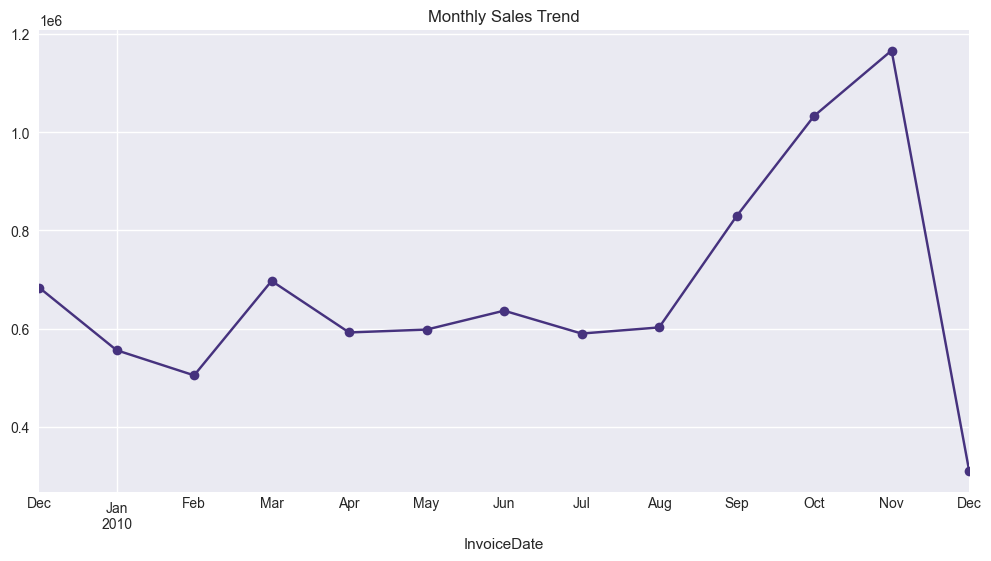

In [25]:
# sales overtime
sales_trend =df.groupby(df["InvoiceDate"].dt.to_period('M'))["TotalAmount"].sum()
sales_trend.plot(kind='line', figsize=(12,6),title="Monthly Sales Trend",marker='o')
plt.show()

##### 4.2 Top products


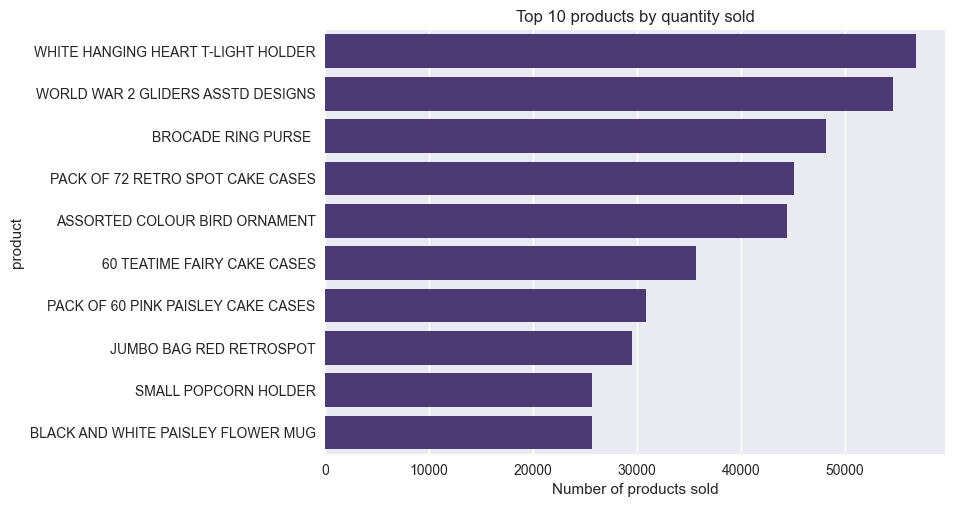

In [26]:
top_products = df.groupby(df["Description"])["Quantity"].sum().nlargest(10)

sns.barplot(x=top_products.values,y=top_products.index)
plt.title("Top 10 products by quantity sold")
plt.ylabel("product")
plt.xlabel("Number of products sold")
plt.show()

##### 4.3 top customers

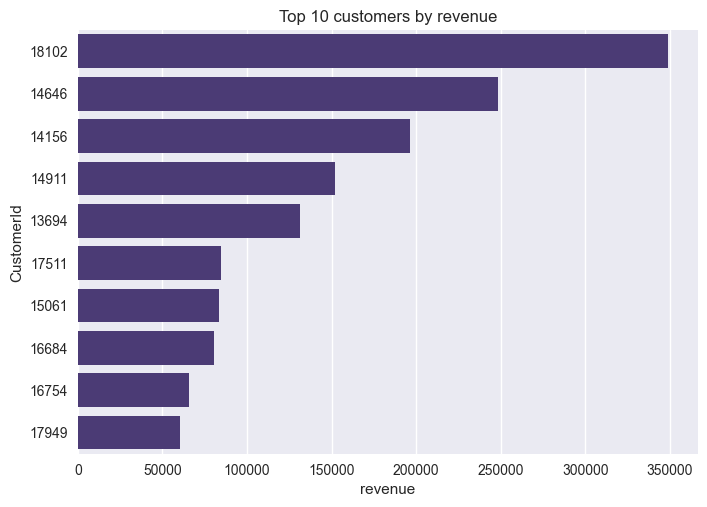

In [27]:
top_customers =df.groupby("CustomerId")['TotalAmount'].sum().nlargest(10)

sns.barplot(x=top_customers.values,y=top_customers.index)
plt.title("Top 10 customers by revenue")
plt.xlabel("revenue")
plt.show()

##### 4.4 Country Analysis

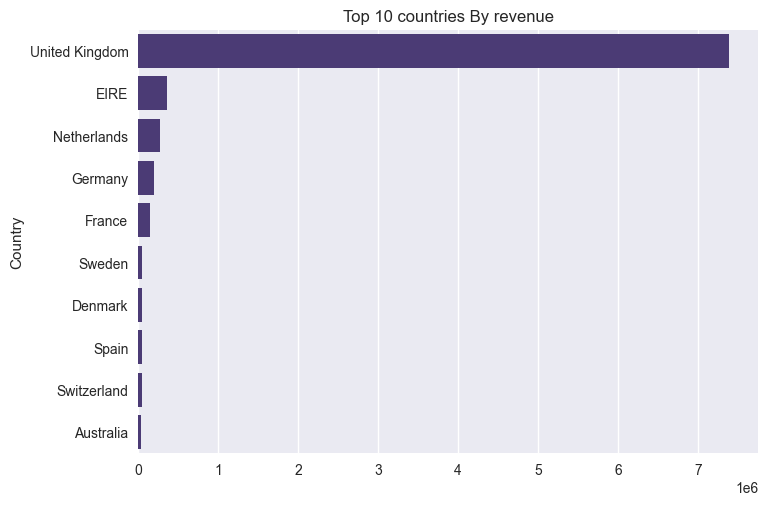

In [28]:
country_sales = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)

sns.barplot(x=country_sales.values,y=country_sales.index)
plt.title("Top 10 countries By revenue")
plt.show()

### 5. Customer segmentation (RFM Analysis /Recency, frequency, Monetary)

##### 5.1 Build RFM table

In [32]:
# snapshot date( last incoice date)
snapshot_date = df['InvoiceDate'].max()+pd.Timedelta(days=1)

# RFM calculation (Recency = snapshot_date - last_purchase_date)
rfm = df.groupby('CustomerId').agg({
    'InvoiceDate':lambda x:(snapshot_date - x.max()).days, # Recency
    'Invoice':'nunique', #Frequency
    'TotalAmount':'sum' # Monetary,
    
})

rfm.rename(columns={
    'InvoiceDate':'Recency',
    'Invoice':'Frequency',
    'TotalAmount':'Monetary'
},inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerId,,,
12346,165,11,372.86
12347,3,2,1323.32
12348,74,1,222.16
12349,43,3,2671.14
12351,11,1,300.93


##### 5.2 Distribution Plots


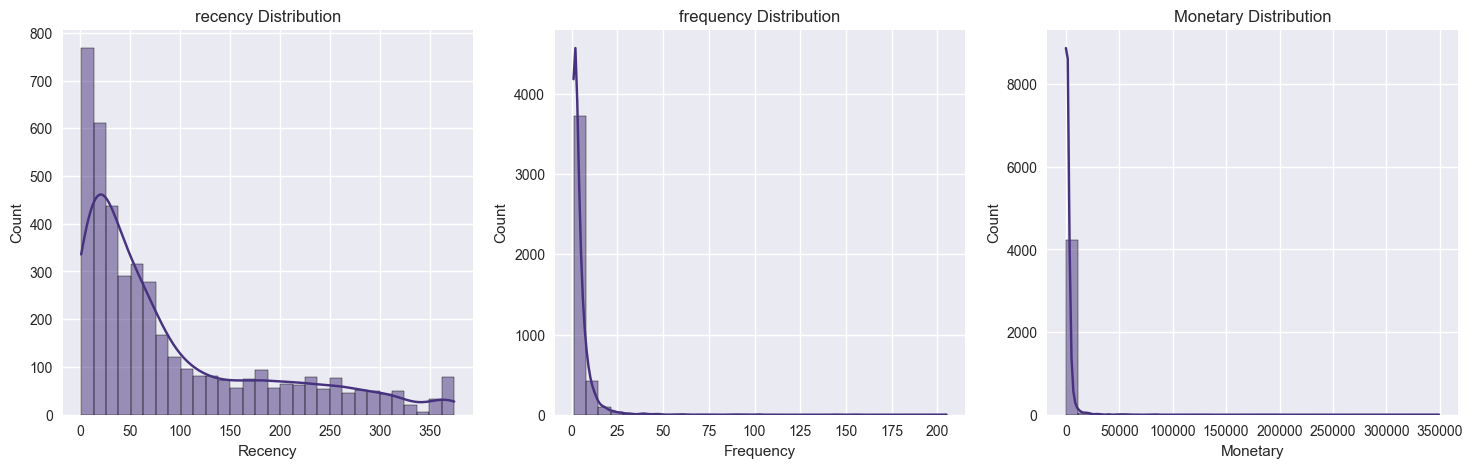

In [30]:
fig, axes = plt.subplots(1,3, figsize=(18,5))

sns.histplot(rfm['Recency'],bins=30,ax=axes[0],kde=True)
axes[0].set_title("recency Distribution")

sns.histplot(rfm['Frequency'],bins=30,ax=axes[1],kde= True)
axes[1].set_title("frequency Distribution")

sns.histplot(rfm['Monetary'],bins=30,ax=axes[2],kde= True)
axes[2].set_title("Monetary Distribution")

plt.show()



##### 5.3 segmenting customers based on rank

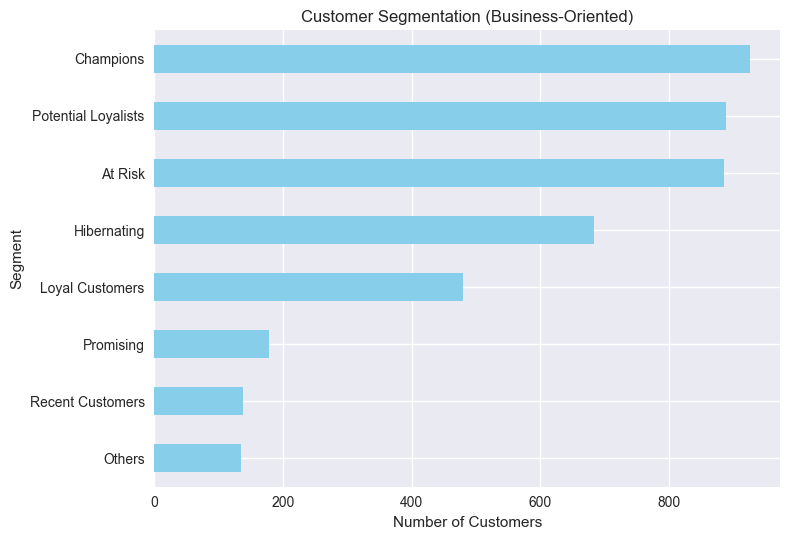

In [37]:
#Assign RFM Scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

#combine scores into rfm score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str)+rfm['M_Score'].astype(str)
# This forms a string like '555' or '312' for each customer.

#customer segments
def segment_customer(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 4:
        return 'Loyal Customers'
    elif r >= 3 and f >= 2:
        return 'Potential Loyalists'
    elif r >= 4 and f <= 2:
        return 'Recent Customers'
    elif r == 3 and f <= 2:
        return 'Promising'
    elif r <= 2 and f >= 2 and m >= 2:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'
    elif r == 1 and f == 1 and m == 1:
        return 'Lost'
    else:
        return 'Others'
rfm['Segment'] = rfm.apply(segment_customer,axis=1)

# Sort segment counts in descending order before plotting
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

# Plot
segment_counts.plot(kind='barh', color='skyblue')
plt.title("Customer Segmentation (Business-Oriented)")
plt.xlabel("Number of Customers")
plt.tight_layout()
plt.show()



In [38]:
segment_summary = rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','sum'],
    'Segment':'count'
}).sort_values(('Monetary','sum'), ascending=False)

segment_summary
# rfm.head()

Recency  Frequency     Monetary              Segment
                           mean       mean         mean          sum   count
Segment                                                                     
Champions             13.672786  11.676026  6168.931638  5712430.697     926
At Risk              161.532731   3.188488  1358.804426  1203900.721     886
Loyal Customers       39.632568   5.384134  1766.041132   845933.702     479
Potential Loyalists   33.399325   2.006749   756.152992   672220.010     889
Hibernating          219.816984   1.023426   196.068523   133914.801     683
Others               196.746269   1.485075   801.474948   107397.643     134
Promising             53.426966   1.000000   402.829775    71703.700     178
Recent Customers      19.481752   1.000000   370.310000    50732.470     137

### 6. Clustering (KMeans on RFM)

##### 6.1 scaling Data

In [39]:
# # For clustering, only keep numeric RFM values
rfm_features = rfm[['Recency','Frequency','Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

rfm_scaled[:5]


array([[ 0.76229851,  0.80108727, -0.18713934],
       [-0.91040156, -0.3006029 , -0.08047459],
       [-0.17730462, -0.42301292, -0.20405155],
       [-0.4973892 , -0.17819288,  0.07078363],
       [-0.82779909, -0.42301292, -0.19521163]])

##### 6.2 Find Optimal Cluster (Elbow Method)

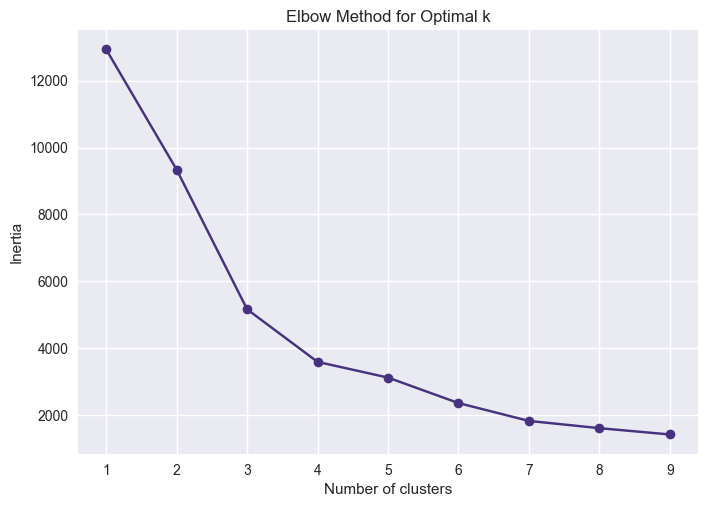

In [40]:
inertia = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,10), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()    


##### 6.3 Apply Kmeans

In [35]:
kmeans =KMeans(n_clusters=4,random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

##### 6.4 Segmentation + Clustering Combined

Cluster                0    1  2   3
Segment                             
At Risk              454  429  0   3
Champions            869    0  5  52
Hibernating          160  523  0   0
Loyal Customers      478    0  0   1
Others                39   95  0   0
Potential Loyalists  889    0  0   0
Promising            178    0  0   0
Recent Customers     137    0  0   0


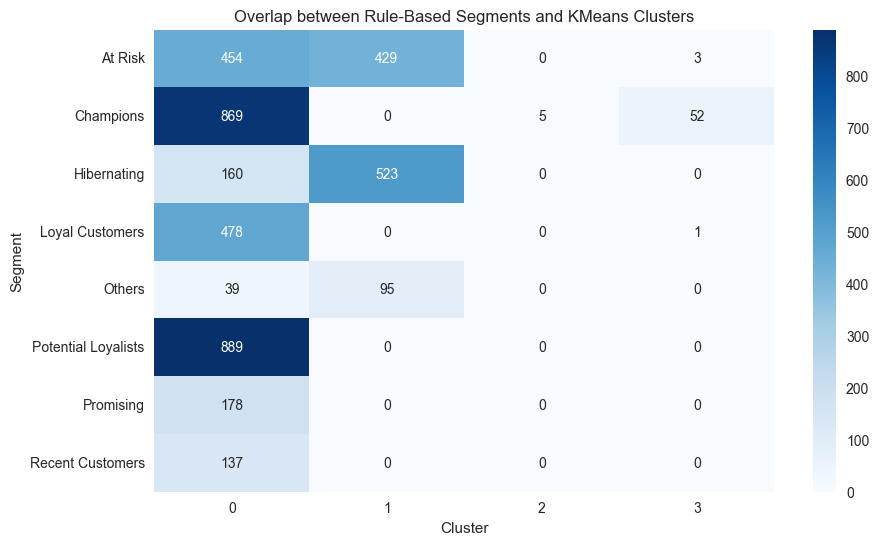

            Recency   Frequency       Monetary
Cluster                                       
0         43.031835    4.455056    1710.650030
1        242.976122    1.659981     593.540319
2          5.600000  113.600000  215535.000000
3         14.910714   47.017857   28896.416661


In [45]:
# Keep only numeric features for clustering
rfm_features = rfm[['Recency','Frequency','Monetary']]

# Scale data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Run KMeans (choose k from Elbow/analysis, e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

# compare segments vs clusters
comparison_table = pd.crosstab(rfm['Segment'],rfm['Cluster'])
print(comparison_table)

# heat map to visualize the data
plt.figure(figsize=(10,6))
sns.heatmap(comparison_table,annot=True,fmt='d',cmap='Blues')
plt.title("Overlap between Rule-Based Segments and KMeans Clusters")
plt.show()

# cluster profiling
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
print(cluster_profile)



### 7. Cluster Analysis & Visualization

##### 7.1 Cluster Summary

In [42]:
# Only select numeric columns for mean calculation
numeric_cols = ['Recency', 'Frequency', 'Monetary']
cluster_summary = rfm.groupby('Cluster')[numeric_cols].mean()
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,43.031835,4.455056,1710.650030
1,242.976122,1.659981,593.540319
2,5.600000,113.600000,215535.000000
3,14.910714,47.017857,28896.416661


##### 7.2 Visuaize clusters

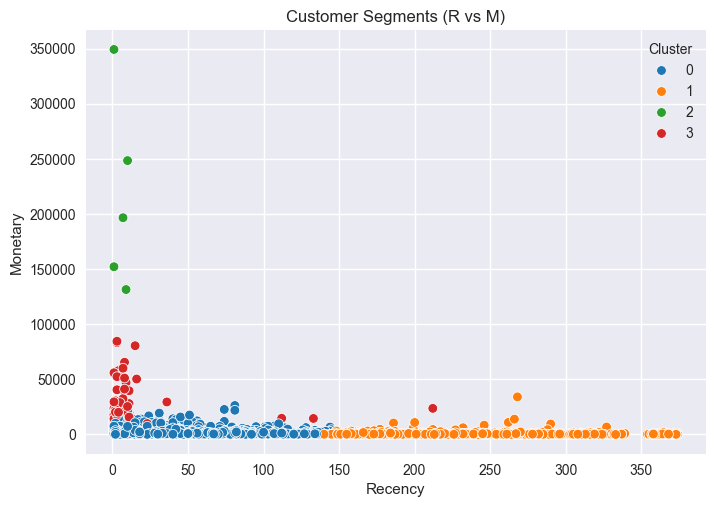

In [ ]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Customer Segments (R vs M)")
plt.show()


### 8. Churn Analysis

##### 8.1 Define the churn label

In [47]:
#We’ll define churn as:
#  Customers who have not purchased in the last 3 months of the dataset window.

# Last purchase date per customer
last_purchase = df.groupby('CustomerId')['InvoiceDate'].max().reset_index()

# Cutoff date = 3 months before dataset max
cutoff_date = df['InvoiceDate'].max() - pd.Timedelta(days=90)

# Label churn
last_purchase['Churned'] = last_purchase['InvoiceDate'] < cutoff_date
# Merge back into RFM dataframe

# Remove Churned if it already exists
if 'Churned' in rfm.columns:
    rfm = rfm.drop(columns=['Churned'])

# Now merge safely
rfm = rfm.merge(last_purchase[['CustomerId', 'Churned']], on='CustomerId', how='left')

rfm[['Recency','Frequency','Monetary','Segment','Cluster','Churned']].head()
rfm.head()
rfm.to_csv("customer_segments.csv")

##### 8.2 Overal Churn Rate

Overall Churn Rate :33.28%


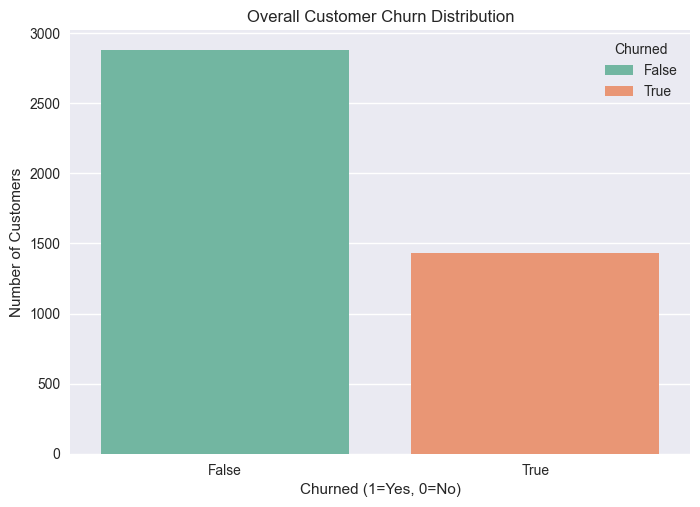

In [ ]:
churn_rate = rfm['Churned'].mean() *100
print(f'Overall Churn Rate :{churn_rate:.2f}%')

sns.countplot(x='Churned', data=rfm, palette="Set2",hue="Churned")
plt.title("Overall Customer Churn Distribution")
plt.xlabel("Churned (1=Yes, 0=No)")
plt.ylabel("Number of Customers")
plt.show()

##### 8.3 Churn by RFM segment

C:\Users\dante\AppData\Local\Temp\ipykernel_2196\1159560025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_segment.values, y=churn_by_segment.index, palette="Reds_r")


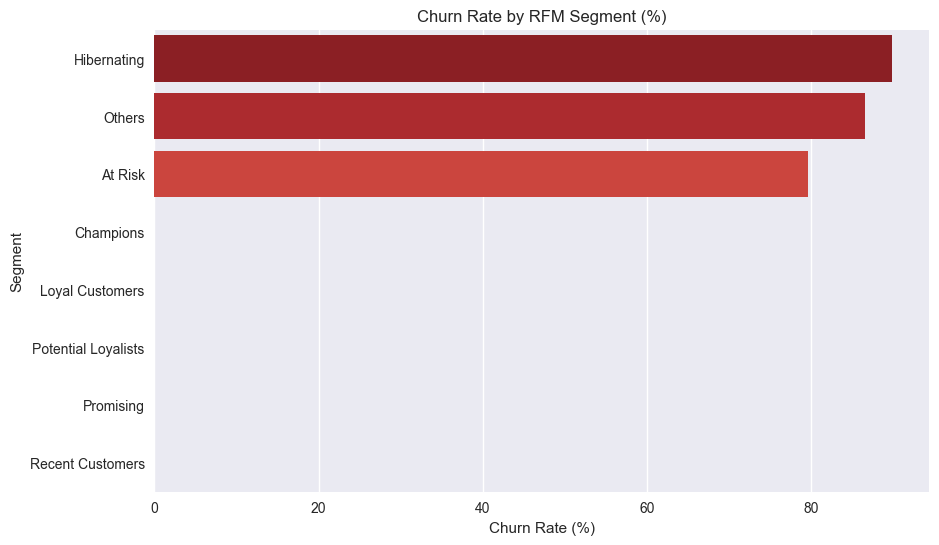

Segment
Hibernating            89.897511
Others                 86.567164
At Risk                79.571106
Champions               0.000000
Loyal Customers         0.000000
Potential Loyalists     0.000000
Promising               0.000000
Recent Customers        0.000000
Name: Churned, dtype: float64

In [ ]:
churn_by_segment = rfm.groupby('Segment')['Churned'].mean().sort_values(ascending=False) *100

plt.figure(figsize=(10,6))
sns.barplot(x=churn_by_segment.values, y=churn_by_segment.index, palette="Reds_r")
plt.title("Churn Rate by RFM Segment (%)")
plt.xlabel("Churn Rate (%)")
plt.ylabel("Segment")
plt.show()
churn_by_segment

##### 8.4 Churn By cluster


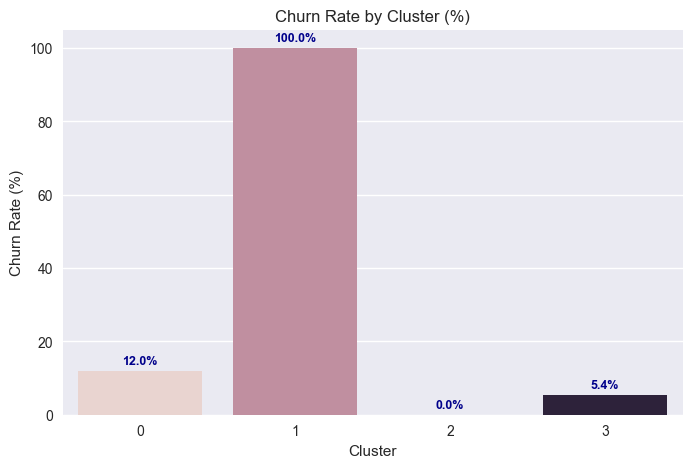

Cluster
1    100.000000
0     12.016230
3      5.357143
2      0.000000
Name: Churned, dtype: float64

In [ ]:
churn_by_cluster = rfm.groupby('Cluster')['Churned'].mean().sort_values(ascending=False) *100

plt.figure(figsize = (8,5))
ax = sns.barplot(x=churn_by_cluster.index,y=churn_by_cluster.values,hue=churn_by_cluster.index,legend=False)

# Annotate bars with churn %
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax.text(
        x,
        height + 1,
        f"{height:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        color='darkblue',
        fontweight='bold'
    )

plt.title("Churn Rate by Cluster (%)")
plt.xlabel("Cluster")
plt.ylabel("Churn Rate (%)")
plt.show()
churn_by_cluster

##### 8.5 Cross segmentation (segment +clusters)

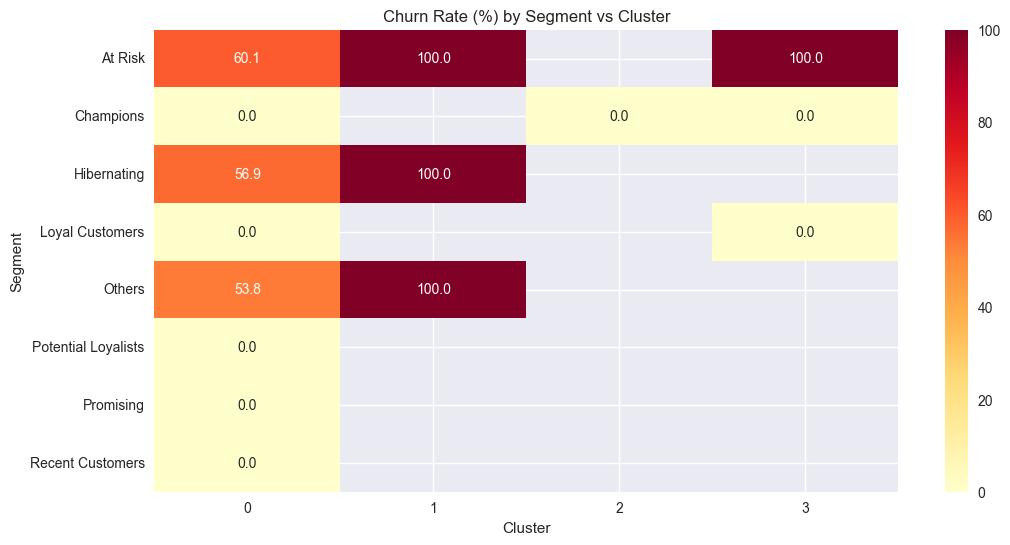

Cluster,0,1,2,3
Segment,,,,
At Risk,60.132159,100.0,NaN,100.0
Champions,0.000000,NaN,0.0,0.0
Hibernating,56.875000,100.0,NaN,NaN
Loyal Customers,0.000000,NaN,NaN,0.0
Others,53.846154,100.0,NaN,NaN
Potential Loyalists,0.000000,NaN,NaN,NaN
Promising,0.000000,NaN,NaN,NaN
Recent Customers,0.000000,NaN,NaN,NaN


In [ ]:
churn_cross = pd.crosstab(rfm['Segment'],rfm['Cluster'],values=rfm['Churned'],aggfunc='mean')*100

plt.figure(figsize=(12,6))
sns.heatmap(churn_cross, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Churn Rate (%) by Segment vs Cluster")
plt.show()
churn_cross

### 9 . forecasting


20:30:32 - cmdstanpy - INFO - Chain [1] start processing
20:30:32 - cmdstanpy - INFO - Chain [1] done processing


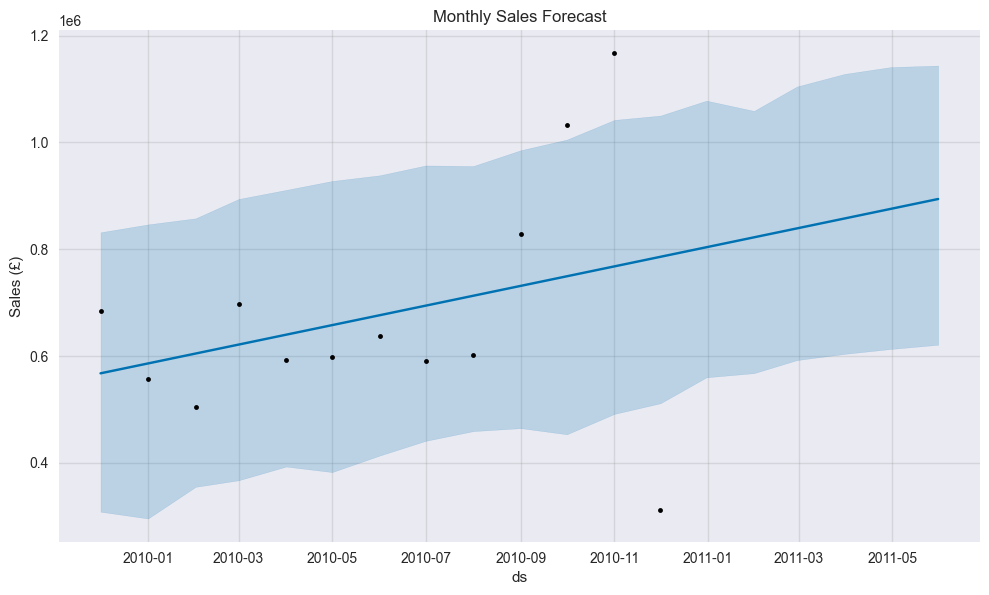

In [50]:
from prophet import Prophet

# Aggregate monthly sales
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum().reset_index()
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()

# Prepare data for Prophet
sales = monthly_sales.rename(columns={'InvoiceDate':'ds','TotalAmount':'y'})

# Build and fit model
model = Prophet()
model.fit(sales)

# Make forecast for next 6 months
future = model.make_future_dataframe(periods=6, freq='ME')
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Monthly Sales Forecast")
plt.ylabel("Sales (£)")
plt.show()
